In [1]:
from pathlib import Path
import pyart
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

from prepro.nexrad import prune_nexrad
from cappi.azran import make_cappi
from cappi.make_vv import simple_vv, get_indexed_vv
from mcit.vil import get_vil_from_azran
from make_logger import logger

#viewable plots
import matplotlib.pyplot as plt
from klaus_krause_cmap import get_zdr_cmap, get_obj_cmap
from config import _EXAMPLEDATA_DIR



In [3]:
filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KOAX20140603_213649_V06.gz')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KEWX20210504_020040_V06')
#filename = Path(_EXAMPLEDATA_DIR, 'nexrad_level2', 'KSHV20230613_230228_V06')

#read in the Level 2 WSR-88D data as a pyart object
radar_vol = pyart.io.read_nexrad_archive(filename)


In [4]:
#remove extra sweeps of data. Keep only data
#from the survelience cuts and one cut per volume 
prune_actions = ['surv', 'volume']
prune_vol = prune_nexrad(prune_actions, radar_vol)



In [5]:
#create an indexed version of the data on 360 radials
#to a range of 1200 (defaults) at 250m gates.
#We also change formats here to an xarray datastore
#working with xarrys is easier for us than pyart objects
ds = get_indexed_vv(prune_vol, fields=['reflectivity'])


2024-11-22 14:22:49,960 [MainThread  ] [INFO ]  1 of 14 current_elev: 0.48
2024-11-22 14:22:50,011 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:22:50,011 [MainThread  ] [INFO ]  2 of 14 current_elev: 0.88
2024-11-22 14:22:50,061 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:22:50,062 [MainThread  ] [INFO ]  3 of 14 current_elev: 1.32
2024-11-22 14:22:50,111 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:22:50,112 [MainThread  ] [INFO ]  4 of 14 current_elev: 1.80
2024-11-22 14:22:50,141 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:22:50,142 [MainThread  ] [INFO ]  5 of 14 current_elev: 2.42
2024-11-22 14:22:50,171 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-11-22 14:22:50,172 [MainThread  ] [INFO ]  6 of 14 current_elev: 3.12
2024-11-22 14:22:50,202 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, nu

In [6]:
#compute VIL from the indexed volume of reflectivity
vil = get_vil_from_azran(ds['reflectivity'])
vil.attrs.update(ds.attrs)
#this adds the vil to the xarray dataset we are building


In [7]:
#
#convert the AzRan image to XY coordinates
#
from cappi.xy_cappi import azran_to_xy

x_trg = np.arange(-300, 301)
y_trg = np.arange(-300, 301)

vil_xy = azran_to_xy(vil, x_trg, y_trg, grid_spacing_meters=1000.0)




In [8]:
from mcit.mcit_objects import mcit_objects, mcit_trim

In [9]:
mcit_raw = mcit_objects(vil_xy)
mcit_final = mcit_trim(mcit_raw, vil_xy, 5, 50)

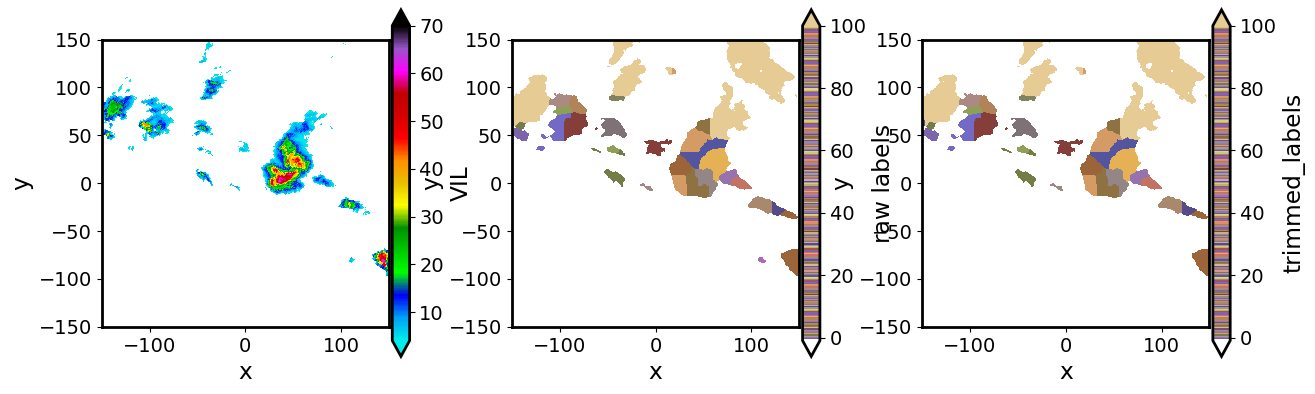

In [10]:
#plot some results
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('dark_background')

plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )

axislabels = ["X (km)", "Y (km)"]
axisXlabels = ["X (km)", ""]
axisYlabels = ["", "Y (km)"]
axisnonelabels = ["", ""]
xlim = [-150, 150]
ylim = [-150, 150]
xdiff = xlim[1] - xlim[0]
axps = xdiff * 0.075
ayps = xdiff * 0.025



fig = plt.figure(figsize=(15, 5))
object_cmap = get_obj_cmap()


ax1 = fig.add_subplot(131)
ax1.set_aspect('equal')
ax1.set_ylabel('')
ax1.set_title("")
vil_xy.where(vil_xy > 4).plot(ax=ax1, x="x", y="y", vmin=4, vmax=70,
                               xlim=xlim, ylim=ylim, cmap='pyart_NWSRef',
                               add_colorbar=True,
                               cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'VIL', 'shrink':0.9})


ax2 = fig.add_subplot(132)
ax2.set_aspect('equal')
ax2.set_ylabel('')
ax2.set_title("")

mcit_raw.plot(ax=ax2, x='x', y='y', vmin=-1.0, vmax=100.0,
              xlim=xlim, ylim=ylim, cmap=object_cmap,
              add_colorbar=True, 
              cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'raw labels', 'shrink':0.9})


ax3 = fig.add_subplot(133)
ax3.set_aspect('equal')
ax3.set_ylabel('')
ax3.set_title("")

mcit_final.plot(ax=ax3, x='x', y='y', vmin=-1.0, vmax=100.0,
                xlim=xlim, ylim=ylim, cmap=object_cmap,
                add_colorbar=True, 
                cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'trimmed_labels', 'shrink':0.9})

plt.show()

#out_filename = Path("./test.png")
#fig.savefig(out_filename)
plt.close(fig)